<a href="https://colab.research.google.com/github/Platayo/Well-log-FluidType-Lithology-Prediction/blob/main/FYP_fluidtype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lasio
!pip install petrolib

###Load train and test dataset

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import lasio as las

import random

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
## defining file paths
train_data_path = "drive/My Drive/exported_logs_ORIGINAL/train_wells"
test_data_path = "drive/MyDrive/exported_logs_ORIGINAL/test_wells"
Pearl_01 = f"{train_data_path}/pearl 01.las"
Pearl_02 = f"{train_data_path}/pearl 02.las"
Pearl_03 = f"{train_data_path}/pearl 03.las"
Pearl_04 = f"{train_data_path}/pearl 04.las"
Ataga_05 = f"{train_data_path}/ataga 05.las"
Ataga_07 = f"{train_data_path}/ataga 07.las"
Ataga_10 = f"{train_data_path}/ataga 10.las"
Ataga_11 = f"{train_data_path}/ataga 11.las"

#####Loading and reading Pearl wells

In [ ]:
## reading the las files
pearl_01 = las.read(Pearl_01)
pearl_02 = las.read(Pearl_02)
pearl_03 = las.read(Pearl_03)
pearl_04 = las.read(Pearl_04)

# convert las files to pandas dataframe
df_pearl_01 = pearl_01.df()
df_pearl_02 = pearl_02.df()
df_pearl_03 = pearl_03.df()
df_pearl_04 = pearl_04.df()

#drop unneeded logs
df_pearl_01 = df_pearl_01.drop(columns=["CALI","SONIC","FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
df_pearl_02 = df_pearl_02.drop(columns=["CALI","SONIC","FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
df_pearl_03 = df_pearl_03.drop(columns=["SONIC", "FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
df_pearl_04 = df_pearl_04.drop(columns=["CALI","SONIC","FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])

# add a well name column
df_pearl_01.insert(0,'WELLNAME','Pearl 01')
df_pearl_02.insert(0,'WELLNAME','Pearl 02')
df_pearl_03.insert(0,'WELLNAME','Pearl 03')
df_pearl_04.insert(0,'WELLNAME','Pearl 04')

# concatenating all the wells together
Pearl = pd.concat([df_pearl_01,df_pearl_02, df_pearl_03, df_pearl_04 ], axis=0, ignore_index=False)

In [ ]:
Pearl

,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY
DEPT,,,,,,,
898.94,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
899.44,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
899.94,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
900.44,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
900.94,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7990.50,Pearl 04,2.1802,100.891098,0.098601,1.5735,3.0,1.0
7991.00,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN
7991.50,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN


In [ ]:
Pearl.tail()

,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY
DEPT,,,,,,,
7990.5,Pearl 04,2.1802,100.891098,0.098601,1.5735,3.0,1.0
7991.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN
7991.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN
7992.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN
7992.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN


#####Loading and reading Ataga wells

In [ ]:
## reading las files
ataga_05 = las.read(Ataga_05)
ataga_07 = las.read(Ataga_07)
ataga_10 = las.read(Ataga_10)
ataga_11 = las.read(Ataga_11)

# convert to pandas dataframe
df_ataga_05 = ataga_05.df()
df_ataga_07 = ataga_05.df()
df_ataga_10 = ataga_05.df()
df_ataga_11 = ataga_05.df()

# rename some log curves
df_ataga_05 = df_ataga_05.rename(columns={'RHOB':'DENS','ILD':'RES'})

df_ataga_07 = df_ataga_07.rename(columns={'RHOB':'DENS','ILD':'RES'})

df_ataga_10 = df_ataga_10.rename(columns={'RHOB':'DENS','ILD':'RES'})

df_ataga_11 = df_ataga_11.rename(columns={'RHOB':'DENS','ILD':'RES'})

## Drop unneeded logs
df_ataga_05 = df_ataga_05.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
df_ataga_07 = df_ataga_07.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
df_ataga_10 = df_ataga_10.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
df_ataga_11 = df_ataga_11.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])

## insert well names
df_ataga_05.insert(0,"WELLNAME","Ataga 05")
df_ataga_07.insert(0,"WELLNAME","Ataga 07")
df_ataga_10.insert(0,"WELLNAME","Ataga 10")
df_ataga_11.insert(0,"WELLNAME","Ataga 11")

## concatenating the wells together
Ataga = pd.concat([df_ataga_05,df_ataga_07,df_ataga_10,df_ataga_11], axis=0, ignore_index=False)

In [ ]:
len(Ataga.columns), len(Pearl.columns)

(7, 7)

#####loading and reading Freeman wells

In [ ]:
## reading test dataset
freeman_03_st = f"{test_data_path}/freeman_003_st1.las"
freeman_05 = f"{test_data_path}/freeman_005.las"
freeman_01 = f"{test_data_path}/freeman_01.las"

Freeman_03_st = las.read(freeman_03_st)
Freeman_05 = las.read(freeman_05)
Freeman_01 = las.read(freeman_01)

## turn to pandas datframe
Freeman_03_st_df = Freeman_03_st.df()
Freeman_05_df = Freeman_05.df()
Freeman_01_df = Freeman_01.df()

## drop unneeded logs
Test_1 = Freeman_03_st_df.drop(columns=["FL","DT","VSH","PHID","SW","F","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
Test_2 = Freeman_05_df.drop(columns=["FL","DT","VSH","PHID","SW","F","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])
Test_3 = Freeman_01_df.drop(columns=["FL","DT","VSH","PHID","SW","F","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF"])

## Rename logs
Test_1 = Test_1.rename(columns= {'DEN':'DENS','NEU':'NPHI','LITHOLOGIES':'LITHOLOGY','RES_DEP':'RES'})
Test_2 = Test_2.rename(columns= {'DEN':'DENS','NEUT':'NPHI','LITHOLOGIES':'LITHOLOGY','RES_DEP':'RES'})
Test_3 = Test_3.rename(columns= {'DEN':'DENS','NEUT':'NPHI','LITHOLOGIES':'LITHOLOGY','RES_DEP':'RES'})

## insert well names
Test_1.insert(0,"WELLNAME","Freeman_03_st")
Test_2.insert(0,"WELLNAME","Freeman_05")
Test_3.insert(0,"WELLNAME","Freeman_01")

In [ ]:
Test_1.shape

(8214, 7)

In [ ]:
Test_2.shape

(11152, 7)

In [ ]:
Test_3.shape

(19991, 7)

##Freeman 3st1

In [ ]:
# concatenate pearl, Ataga, Test_3, Test_2
train_data = pd.concat ((Pearl,Ataga,Test_2,Test_3))
train_data = train_data.reset_index()
Test_1 = Test_1.reset_index()

In [ ]:
Test_1.columns

Index(['DEPT', 'WELLNAME', 'DENS', 'GR', 'NPHI', 'RES', 'LITHOLOGY',
       'FLUIDTYPES'],
      dtype='object')

In [ ]:
Test_1['FLUIDTYPES'].value_counts()

2.0    5546
1.0    1765
0.0     431
3.0     236
Name: FLUIDTYPES, dtype: int64

#####Preparing Validation dataset

In [ ]:
random.seed(42)

In [ ]:
# select two random wells from the 8 training wells for validation
valid_data = random.sample(list(train_data.WELLNAME.unique()),2)
print (valid_data)

['Ataga 05', 'Pearl 04']


In [ ]:
valid_data_list = []

for well in valid_data:
    well_data = train_data.loc[train_data.WELLNAME == well]
    valid_data_list.append(well_data)

validation_data = pd.concat(valid_data_list)

In [ ]:
validation_data.shape

(31224, 8)

In [ ]:
validation_data.head()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY
48165,1325.1180,Ataga 05,NaN,77.943199,NaN,NaN,NaN,1.0
48166,1325.2704,Ataga 05,NaN,77.943199,NaN,NaN,NaN,1.0
48167,1325.4228,Ataga 05,NaN,77.943199,NaN,NaN,3.0,1.0
48168,1325.5752,Ataga 05,NaN,77.943199,NaN,NaN,3.0,1.0
48169,1325.7276,Ataga 05,NaN,77.943199,NaN,-0.0569,3.0,1.0


In [ ]:
validation_data.tail()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY
48160,7990.5,Pearl 04,2.1802,100.891098,0.098601,1.5735,3.0,1.0
48161,7991.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN
48162,7991.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN
48163,7992.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN
48164,7992.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN,NaN


In [ ]:
## separating the validation data into two wells

validation_data_1 = validation_data[validation_data.WELLNAME.isin([valid_data[0]])]
validation_data_2 = validation_data[validation_data.WELLNAME.isin([valid_data[1]])]

In [ ]:
validation_data_2.head()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY
36959,2390.0,Pearl 04,1.6766,23.721600,0.408378,NaN,0.0,0.0
36960,2390.5,Pearl 04,1.6766,23.721600,0.408378,2000.0,0.0,0.0
36961,2391.0,Pearl 04,1.6766,26.095200,0.403776,2000.0,0.0,0.0
36962,2391.5,Pearl 04,1.7441,26.962799,0.410406,2000.0,0.0,0.0
36963,2392.0,Pearl 04,1.7822,25.871000,0.433983,2000.0,0.0,0.0


In [ ]:
new_train_data = pd.concat((train_data,validation_data_1,validation_data_2)).drop_duplicates(keep=False)
print(f'Previous train data shape: {train_data.shape}')
print(f'New train data shape: {new_train_data.shape}')

Previous train data shape: (159380, 8)
New train data shape: (128156, 8)


In [ ]:
# check for data leakage
print (f'Original train data rows: {train_data.shape[0]}')
print (f'New_train + Validation rows: {new_train_data.shape[0] + validation_data_1.shape[0] + validation_data_2.shape[0]}')

Original train data rows: 159380
New_train + Validation rows: 159380


#####Exploratory Data Analysis

In [ ]:
new_train_data.head()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY
0,898.94,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
1,899.44,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
2,899.94,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
3,900.44,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN
4,900.94,Pearl 01,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
new_train_data.tail(5)

,DEPT,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY
159375,13705.5,Freeman_01,2.1419,1.6927,0.471,NaN,3.0,0.0
159376,13706.0,Freeman_01,2.1419,1.6946,0.471,NaN,3.0,0.0
159377,13706.5,Freeman_01,2.1419,1.6966,0.471,NaN,NaN,0.0
159378,13707.0,Freeman_01,2.1419,1.6987,0.471,NaN,NaN,0.0
159379,13707.5,Freeman_01,2.1419,1.7008,0.471,NaN,NaN,NaN


In [ ]:
## number of fluid types
print(f'unique fluid type count: {len(dict(new_train_data.FLUIDTYPES.value_counts()))}')

unique fluid type count: 4


In [ ]:
new_train_data.FLUIDTYPES.value_counts() # 0-Gas, 1-oil, 2-water , 3-undifferentiated

3.0    56995
2.0    49504
1.0    14871
0.0     2650
Name: FLUIDTYPES, dtype: int64

In [ ]:
train_well_items = dict(100-(new_train_data.isna().sum()/new_train_data.shape[0])*100)
train_well_items

{'DEPT': 100.0,
 'WELLNAME': 100.0,
 'DENS': 63.06376603514467,
 'GR': 99.45223009457224,
 'NPHI': 52.29407909110771,
 'RES': 96.95761415774525,
 'FLUIDTYPES': 96.77268329223759,
 'LITHOLOGY': 99.45144979556166}

In [ ]:
## selecting the dataset to be used for training
print("Percentage of values in test_1 logs:")
100 - Test_1.isna().sum()/Test_1.shape[0] * 100

Percentage of values in test_1 logs:


DEPT          100.000000
WELLNAME      100.000000
DENS           96.944242
GR             99.245191
NPHI           96.652057
RES            97.236426
LITHOLOGY      99.245191
FLUIDTYPES     97.126857
dtype: float64

<ipython-input-105-b9e08dec0853>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(train_well_items.keys(),rotation=45)


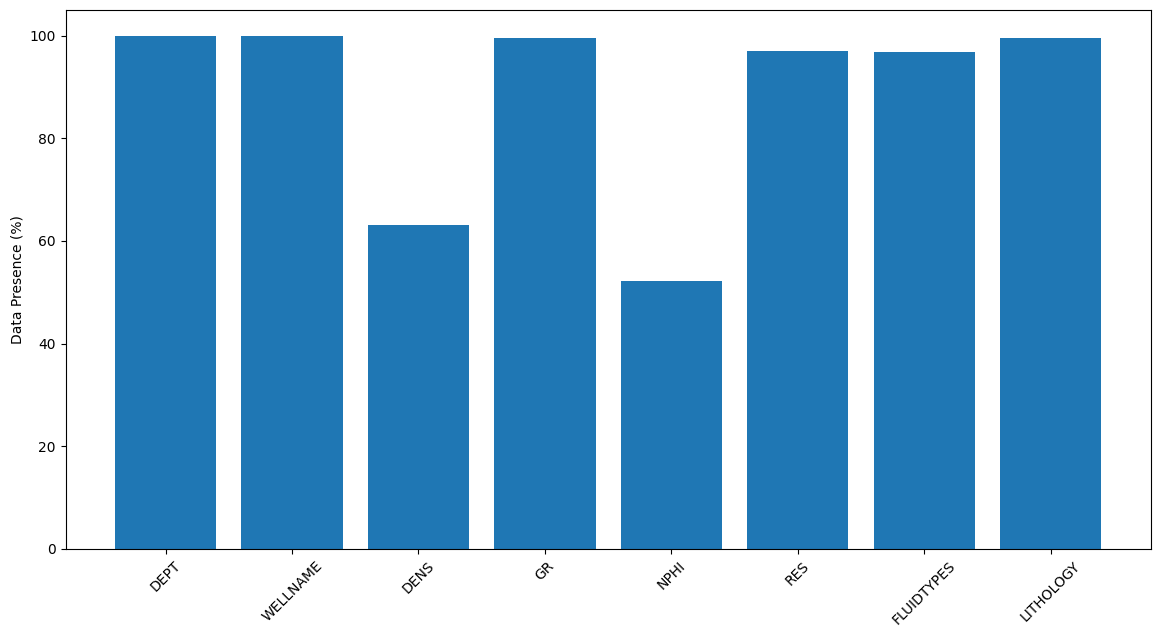

In [ ]:
occurences = np.zeros(len(train_well_items))
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.bar(x = np.arange(occurences.shape[0]),height=train_well_items.values())
ax.set_xticklabels(train_well_items.keys(),rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Data Presence (%)');

In [ ]:
fluidtypes = dict(new_train_data.FLUIDTYPES.value_counts())
fluidtypes

{3.0: 56995, 2.0: 49504, 1.0: 14871, 0.0: 2650}

In [ ]:
fluid_names = ["Undifferentiated","Water","Oil","Gas"]

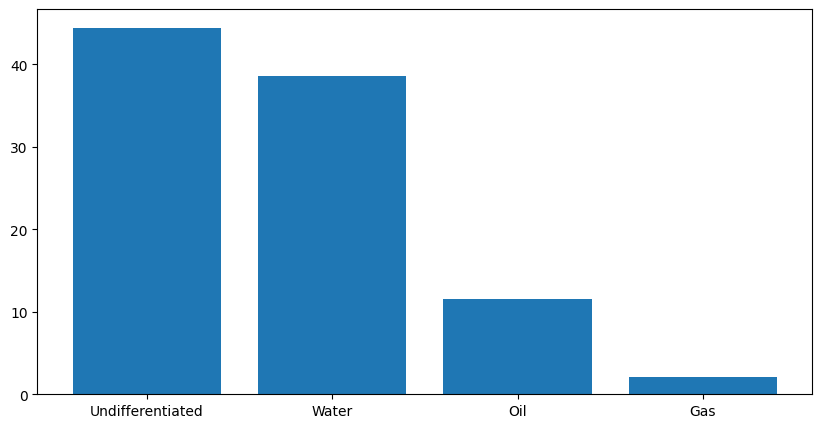

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.bar(fluid_names,(np.array(list(fluidtypes.values()))/new_train_data.shape[0]*100));

####Data cleaning and Preparation

In [ ]:
# row numbers
ntrain = new_train_data.shape[0]
nval_1 = validation_data_1.shape[0]
nval_2 = validation_data_2.shape[0]
ntest_1 = Test_1.shape[0]

In [ ]:
new_train_data.shape

(128156, 8)

In [ ]:
## concatenating new_train_data, Test_1 and val_1,_2 for combined cleaning
df = pd.concat((new_train_data,Test_1,validation_data_1,validation_data_2)).reset_index(drop=True)

In [ ]:
df.shape

(167594, 8)

In [ ]:
## Drop rows where FLUIDTYPES is NAN
df = df.dropna(subset=['FLUIDTYPES'])

# Do the same for LITHOLOGY
df = df.dropna(subset=['LITHOLOGY'])

In [ ]:
# Test 1
count_missing_lithology = pd.isna(Test_1['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(Test_1['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")


count_missing_values = ((pd.isna(Test_1['FLUIDTYPES'])) & (pd.isna(Test_1['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 62
Number of rows with missing values in FLUIDTYPES: 236
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 0


In [ ]:
# Train_data
count_missing_lithology = pd.isna(new_train_data['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(new_train_data['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")


count_missing_values = ((pd.isna(new_train_data['FLUIDTYPES'])) & (pd.isna(new_train_data['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 703
Number of rows with missing values in FLUIDTYPES: 4136
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 633


In [ ]:
# validation 1
count_missing_lithology = pd.isna(validation_data_1['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(validation_data_1['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")


count_missing_values = ((pd.isna(validation_data_1['FLUIDTYPES'])) & (pd.isna(validation_data_1['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 0
Number of rows with missing values in FLUIDTYPES: 54
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 0


In [ ]:
# validation 2
count_missing_lithology = pd.isna(validation_data_2['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(validation_data_2['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")


count_missing_values = ((pd.isna(validation_data_2['FLUIDTYPES'])) & (pd.isna(validation_data_2['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 4
Number of rows with missing values in FLUIDTYPES: 4
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 4


In [ ]:
dropped_train = 703 + 4136 - 633
dropped_test_1 = 236 + 62
dropped_val_1 = 54
dropped_val_2 = 4

In [ ]:
df.isna().sum()

DEPT              0
WELLNAME          0
DENS          57226
GR                0
NPHI          70669
RES            4334
FLUIDTYPES        0
LITHOLOGY         0
dtype: int64

In [ ]:
## calculate median of other numerical variables

#dens_median = df['DENS'].median()
#nphi_median = df['NPHI'].median()
#res_median = df['RES'].median()

In [ ]:
## replace missing values in numerical variables with -999

df['DENS'] = df['DENS'].fillna(-999)
df['NPHI'] = df['NPHI'].fillna(-999)
df['RES'] = df['RES'].fillna(-999)

In [ ]:
df.isna().sum()

DEPT          0
WELLNAME      0
DENS          0
GR            0
NPHI          0
RES           0
FLUIDTYPES    0
LITHOLOGY     0
dtype: int64

In [ ]:
df_copy = df.copy()
df.shape, df_copy.shape

((163032, 8), (163032, 8))

In [ ]:
df_copy.isna().sum()

DEPT          0
WELLNAME      0
DENS          0
GR            0
NPHI          0
RES           0
FLUIDTYPES    0
LITHOLOGY     0
dtype: int64

In [ ]:
## split back the df into train, test and val datasets
train = df_copy[:(ntrain-dropped_train)].copy()
train.drop(['FLUIDTYPES'], axis=1, inplace=True)

test_1 = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1)+ (ntrain-dropped_train))].copy()
test_1.drop(['FLUIDTYPES'],axis=1,inplace=True)
test_1 = test_1.reset_index(drop=True)

val_1 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train)):((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1))].copy()
val_1.drop(['FLUIDTYPES'],axis=1,inplace=True)
val_1 = val_1.reset_index(drop=True)

val_2 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1)):].copy()
val_2.drop(['FLUIDTYPES'],axis=1,inplace=True)
val_2 = val_2.reset_index(drop=True)

In [ ]:
Test_1.head()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY,FLUIDTYPES
0,5633.5,Freeman_03_st,NaN,12.159700,NaN,NaN,0.0,NaN
1,5634.0,Freeman_03_st,NaN,44.075001,NaN,NaN,0.0,NaN
2,5634.5,Freeman_03_st,NaN,44.075001,NaN,NaN,0.0,NaN
3,5635.0,Freeman_03_st,NaN,44.075001,NaN,NaN,0.0,NaN
4,5635.5,Freeman_03_st,NaN,43.715900,NaN,NaN,0.0,NaN


In [ ]:
train.shape[0] + test_1.shape[0] + val_1.shape[0] + val_2.shape[0]

163032

In [ ]:
train.isna().sum()

DEPT         0
WELLNAME     0
DENS         0
GR           0
NPHI         0
RES          0
LITHOLOGY    0
dtype: int64

In [ ]:
df_copy.shape

(163032, 8)

In [ ]:
train.isna().sum()

DEPT         0
WELLNAME     0
DENS         0
GR           0
NPHI         0
RES          0
LITHOLOGY    0
dtype: int64

In [ ]:
# defining X_train and y_train
X_train = train.drop(['DEPT','WELLNAME'], axis=1)
y_train = df_copy[:(ntrain-dropped_train)]['FLUIDTYPES'].astype('int')

In [ ]:
X_train

,DENS,GR,NPHI,RES,LITHOLOGY
37,2.0155,25.944000,-999.000,38.841999,0.0
38,1.9773,25.424999,-999.000,35.256001,0.0
39,1.9485,26.393000,-999.000,31.393999,0.0
40,1.9428,27.667000,-999.000,31.843000,0.0
41,1.9428,29.193001,-999.000,34.314999,0.0
...,...,...,...,...,...
128148,2.1781,1.687900,0.471,-999.000000,0.0
128149,2.1551,1.689400,0.471,-999.000000,0.0
128150,2.1480,1.691000,0.471,-999.000000,0.0
128151,2.1419,1.692700,0.471,-999.000000,0.0


In [ ]:
(y_train.value_counts()/y_train.shape[0])*100

3    45.951593
2    39.928197
1    11.997580
0     2.122630
Name: FLUIDTYPES, dtype: float64

In [ ]:
# defining x_test_1 and y_test_1
X_test_1 = test_1.drop(['DEPT',"WELLNAME"], axis = 1)
y_test_1 = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1) + (ntrain-dropped_train))]['FLUIDTYPES'].astype('int')

In [ ]:
# defining x_val_1,2 and y_val_1,2
X_val_1 = val_1.drop(['DEPT',"WELLNAME"],axis = 1)
y_val_1 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train)):((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1))]['FLUIDTYPES'].astype('int')

X_val_2 = val_2.drop(['DEPT',"WELLNAME"],axis =1)
y_val_2 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1)):]['FLUIDTYPES'].astype('int')

In [ ]:
(y_test_1.value_counts()/y_test_1.shape[0])*100

2    69.959576
1    22.296614
0     5.444669
3     2.299141
Name: FLUIDTYPES, dtype: float64

####RandomForestClassifier model training

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# initializing the model
rfc = RandomForestClassifier(n_estimators = 300,
                             max_depth = 5,
                             random_state=42,
                             verbose =2,
                             bootstrap=True
                            )

# fit the model to the data
rfc.fit(X_train,y_train)

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.0s


building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   14.0s


building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300


RandomForestClassifier(max_depth=5, n_estimators=300, random_state=42,
                       verbose=2)

In [ ]:
# predicitions on the validation datsets

# Ataga 5
y_val_pred_1 = rfc.predict(X_val_1)

# Pearl 04
y_val_pred_2 = rfc.predict(X_val_2)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


In [ ]:
# predictions on the test dataset

# Freeman 3st
y_pred_1 = rfc.predict(X_test_1)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score

acc_test_1 = accuracy_score(y_test_1,y_pred_1)
acc_val_1 = accuracy_score(y_val_1, y_val_pred_1)
acc_val_2 = accuracy_score(y_val_2, y_val_pred_2)

print("Accuracy score for Ataga 5 well: %.5f" % acc_val_1)
print("Accuracy score for pearl 4 well: %.5f" % acc_val_2)
print("--------------------------------------------------")
print ("Accuracy score for Freeman 3st well: %.5f" %acc_test_1)

Accuracy score for Ataga 5 well: 0.79017
Accuracy score for pearl 4 well: 0.37119
--------------------------------------------------
Accuracy score for Freeman 3st well: 0.76680


In [ ]:
(y_test_1.value_counts()[3]/y_test_1.value_counts().sum())*100

2.2991409802930773

In [ ]:
freeman3st = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1)+ (ntrain-dropped_train))]

In [ ]:
freeman3st['FLUIDTYPES'].value_counts()

2.0    5538
1.0    1765
0.0     431
3.0     182
Name: FLUIDTYPES, dtype: int64

In [ ]:
### i am trying to check for the columns of the dataframe to include the
### the predicted fluidtypes. all logs must be present in the dataframe including depth.

freeman3st['PRED_FLUIDTYPES'] = y_pred_1

<ipython-input-397-cb5736a7bed6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freeman3st['PRED_FLUIDTYPES'] = y_pred_1


In [ ]:
freeman3st

,DEPT,WELLNAME,DENS,GR,NPHI,RES,FLUIDTYPES,LITHOLOGY,PRED_FLUIDTYPES
128392,5751.5,Freeman_03_st,1.9693,64.505798,0.6596,0.8223,1.0,0.0,1
128393,5752.0,Freeman_03_st,1.9825,66.839401,0.4478,0.7461,1.0,0.0,1
128394,5752.5,Freeman_03_st,1.8540,67.223999,0.5943,0.6503,1.0,0.0,1
128395,5753.0,Freeman_03_st,1.7136,74.602501,0.6313,0.6298,1.0,0.0,1
128396,5753.5,Freeman_03_st,1.6907,73.149200,0.7020,0.6655,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...
136303,9707.0,Freeman_03_st,2.3517,107.642998,0.5471,1.0566,2.0,1.0,2
136304,9707.5,Freeman_03_st,2.3560,107.927002,0.4412,1.0817,2.0,1.0,2
136305,9708.0,Freeman_03_st,2.3589,108.723000,0.4069,1.1403,2.0,1.0,2
136306,9708.5,Freeman_03_st,2.3579,110.685997,0.4195,1.2142,2.0,1.0,2


In [ ]:
Test_1['WELLNAME'].unique()

array(['Freeman_03_st'], dtype=object)

In [ ]:
freeman3st['RES'].min()

0.2045000046

In [ ]:
## function to plot predictions

def compare_fluidtype_log_plot(logs, x1, x2, x3, x4):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.colors as colors

    logs = logs.sort_values(by='DEPT', ascending=True)
    ztop = logs.DEPT.min(); zbot=logs.DEPT.max()

    #for fluidtypes
    fluidtype_colors = ['r','g', 'b','mistyrose']
    fluidtype_names = ['Gas','Oil','Water','Undifferentiated']
    fluidtype_colormap = {}
    for ind, label in enumerate(fluidtype_names):
        fluidtype_colormap[label] = fluidtype_colors[ind]

    cmap_fluidtype = colors.ListedColormap(
            fluidtype_colors[0 : 4], 'indexed'
            )

    cluster1=np.repeat(np.expand_dims(logs['FLUIDTYPES'].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs['PRED_FLUIDTYPES'].values,1), 100, 1)

    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(10, 10))

    ax[0].plot(logs[x1], logs.DEPT, '-g')
    ax[1].plot(logs[x2], logs.DEPT, '-', color= 'black')
    ax[2].plot(logs[x3], logs.DEPT, '-', color='blue')
    ax[3].plot(logs[x4], logs.DEPT, '-', color='r')

    im=ax[4].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_fluidtype,vmin=0,vmax=3)
    im=ax[5].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_fluidtype,vmin=0,vmax=3)


    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad='5%')
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((45*' ').join([
        'Gas','Oil','Water','Undifferentiated'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    for i in range(len(ax)-3):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel(x1)
    ax[0].set_ylabel('DEPTH')
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(logs[x2].min(), 10)
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(logs[x3].min(), logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(logs[x4].min(), logs[x4].max())
    ax[4].set_xlabel('Actual')
    ax[5].set_xlabel('Predicted')

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[4].set_xticklabels([]); ax[5].set_yticklabels([]);
    ax[6].set_yticklabels([]); ax[5].set_xticklabels([]); ax[6].set_xticklabels([]);


    plt.tight_layout(h_pad=1)
    f.subplots_adjust(wspace = 0.0)
    #f.suptitle('Well: %s'% logs['WELLNAME'].unique(), fontsize=14,y=0.94)

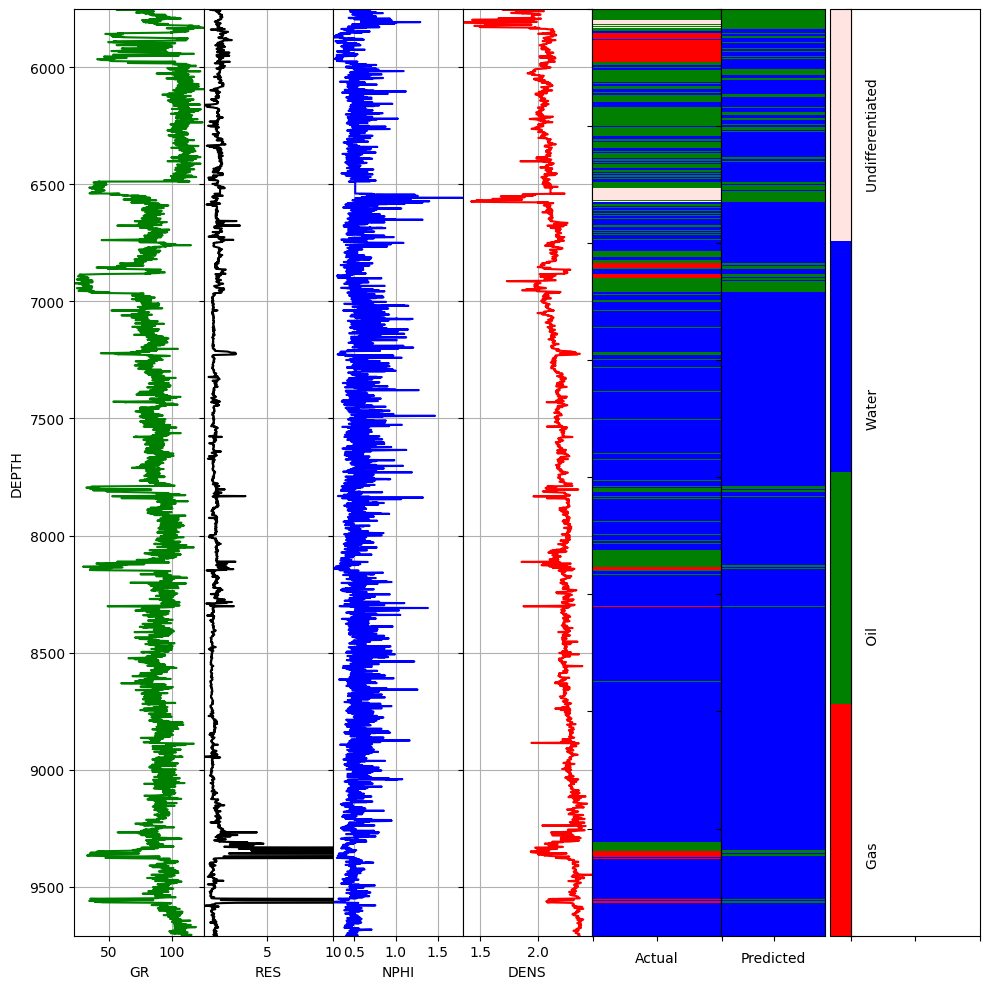

In [ ]:
## visulaize plots
compare_fluidtype_log_plot(freeman3st, 'GR','RES','NPHI','DENS')

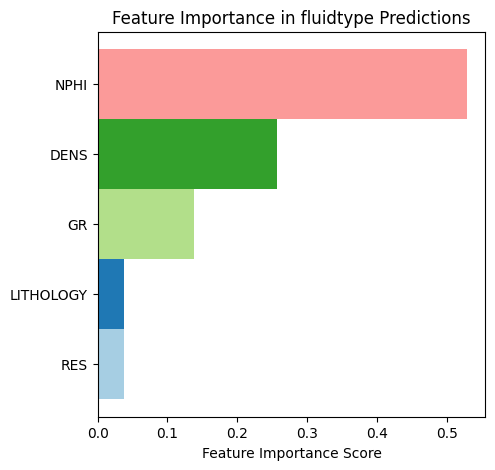

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');

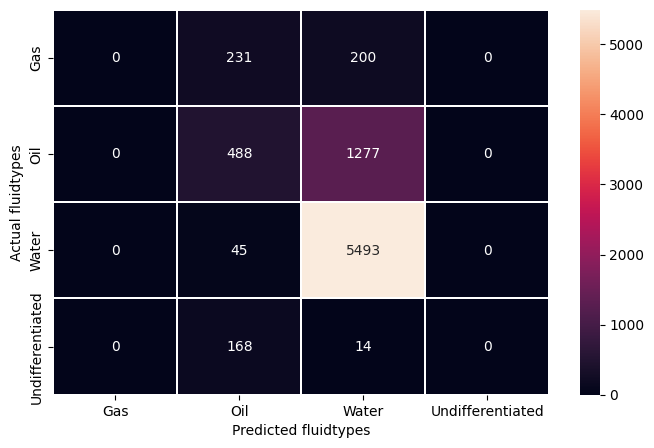

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_1, y_pred_1)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water','Undifferentiated'], columns=['Gas', 'Oil', 'Water','Undifferentiated'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

####XGBoostClassifier Model training

In [ ]:
import xgboost as xgb

num_classes = 4

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

## instantiate xgboost classifier model
xgbc = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=5,
    scale_pos_weight=class_weights
)
## train the model
xgbc.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:16:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Make predictions using the best model
y_pred_1 = xgbc.predict(X_test_1)

In [ ]:
# predicitions on the validation datsets

# Ataga 05
y_val_pred_1 = xgbc.predict(X_val_1)

# Pearl 04
y_val_pred_2 = xgbc.predict(X_val_2)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_1 = accuracy_score(y_test_1,y_pred_1)
acc_val_1 = accuracy_score(y_val_1, y_val_pred_1)
acc_val_2 = accuracy_score(y_val_2, y_val_pred_2)

print("Accuracy score for Pearl 04 well: %.5f" % acc_val_1)
print("Accuracy score for Ataga 11 well: %.5f" % acc_val_2)
print('--------------------------------------')
print("Accuracy score for Freeman 3st well: %.5f" %acc_test_1)



classification_rep_4 = classification_report(y_val_1, y_val_pred_1)
classification_rep_5 = classification_report(y_val_2, y_val_pred_2)
classification_rep_1 = classification_report(y_test_1, y_pred_1)



print (classification_rep_1)
print("------------------------------------------------------")
print (classification_rep_4)
print (classification_rep_5)

Accuracy score for Pearl 04 well: 0.99314
Accuracy score for Ataga 11 well: 0.80736
--------------------------------------
Accuracy score for Freeman 3st well: 0.80382
              precision    recall  f1-score   support

           0       0.49      0.06      0.11       431
           1       0.66      0.54      0.59      1765
           2       0.84      0.97      0.90      5538
           3       0.00      0.00      0.00       182

    accuracy                           0.80      7916
   macro avg       0.50      0.39      0.40      7916
weighted avg       0.76      0.80      0.77      7916

------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.95      0.96      0.95      1497
           2       0.99      0.99      0.99      5032
           3       1.00      1.00      1.00     13370

    accuracy                           0.99     19964
   macro avg    

In [ ]:
freeman3st_1 = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1)+ (ntrain-dropped_train))]
freeman3st_1['PRED_FLUIDTYPES'] = y_pred_1

<ipython-input-141-3cc39bc7e1b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freeman3st_1['PRED_FLUIDTYPES'] = y_pred_1


In [ ]:
#freeman3st_1

In [ ]:
# visulaize plot
compare_fluidtype_log_plot(freeman3st_1,'GR','RES','NPHI','DENS')

NameError: name 'compare_fluidtype_log_plot' is not defined

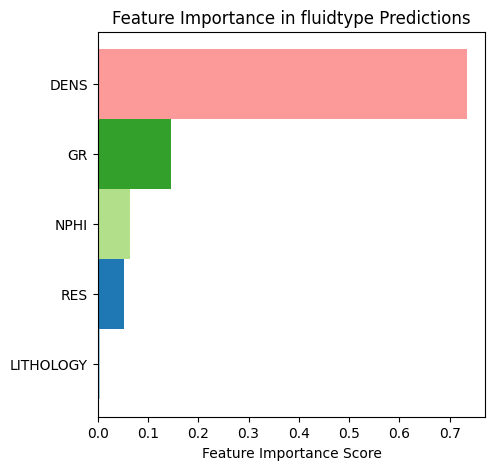

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');

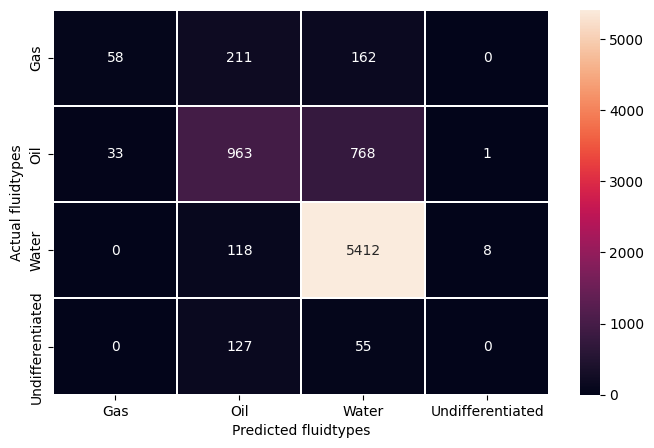

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_1, y_pred_1)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water','Undifferentiated'], columns=['Gas', 'Oil', 'Water','Undifferentiated'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

In [ ]:
## save model
import pickle
import joblib

In [ ]:
filename = 'fluid_prediction_model_xgbc.sav'
#pickle.dump(xgbc, open(filename, 'wb'))

joblib.dump(xgbc, 'work.pkl')

['work.pkl']

In [ ]:
## load the saved model
#loaded_model = pickle.load(open('fluid_prediction_model_xgbc.sav','rb'))

####CatboostClassifier model training

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test_1, label = y_test_1)

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

catboost_model = CatBoostClassifier(class_weights=class_weights,iterations = 500, depth=10, learning_rate=0.1, loss_function='MultiClass' )
catboost_model.fit(train_pool, eval_set= test_pool, early_stopping_rounds=50, verbose=100)

0:	learn: 1.1907174	test: 1.2893731	best: 1.2893731 (0)	total: 178ms	remaining: 1m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9616868913
bestIteration = 21

Shrink model to first 22 iterations.


In [ ]:
# predicitions on the validation datsets

# Ataga 05
y_val_pred_1 = catboost_model.predict(X_val_1)

# Pearl 04
y_val_pred_2 = catboost_model.predict(X_val_2)

In [ ]:
# predictions on the test datasets

# Freeman 3st
y_pred_1 = catboost_model.predict(X_test_1)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_1 = accuracy_score(y_test_1,y_pred_1)
acc_val_1 = accuracy_score(y_val_1, y_val_pred_1)
acc_val_2 = accuracy_score(y_val_2, y_val_pred_2)

print("Accuracy score for Pearl 04 well: %.5f" % acc_val_1)
print("Accuracy score for Ataga 11 well: %.5f" % acc_val_2)
print('--------------------------------------')
print("Accuracy score for Freeman 3st well: %.5f" %acc_test_1)



classification_rep_4 = classification_report(y_val_1, y_val_pred_1)
classification_rep_5 = classification_report(y_val_2, y_val_pred_2)
classification_rep_1 = classification_report(y_test_1, y_pred_1)



print (classification_rep_1)
print("------------------------------------------------------")
print (classification_rep_4)
print (classification_rep_5)

Accuracy score for Pearl 04 well: 0.96674
Accuracy score for Ataga 11 well: 0.60275
--------------------------------------
Accuracy score for Freeman 3st well: 0.80167
              precision    recall  f1-score   support

           0       0.48      0.35      0.40       431
           1       0.58      0.59      0.59      1765
           2       0.89      0.93      0.91      5538
           3       0.00      0.00      0.00       182

    accuracy                           0.80      7916
   macro avg       0.49      0.47      0.47      7916
weighted avg       0.78      0.80      0.79      7916

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        65
           1       0.71      0.96      0.82      1497
           2       0.99      0.89      0.93      5032
           3       1.00      1.00      1.00     13370

    accuracy                           0.97     19964
   macro avg    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

<ipython-input-420-ea6f463ab3c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freeman3st_2['PRED_FLUIDTYPES'] = y_pred_1


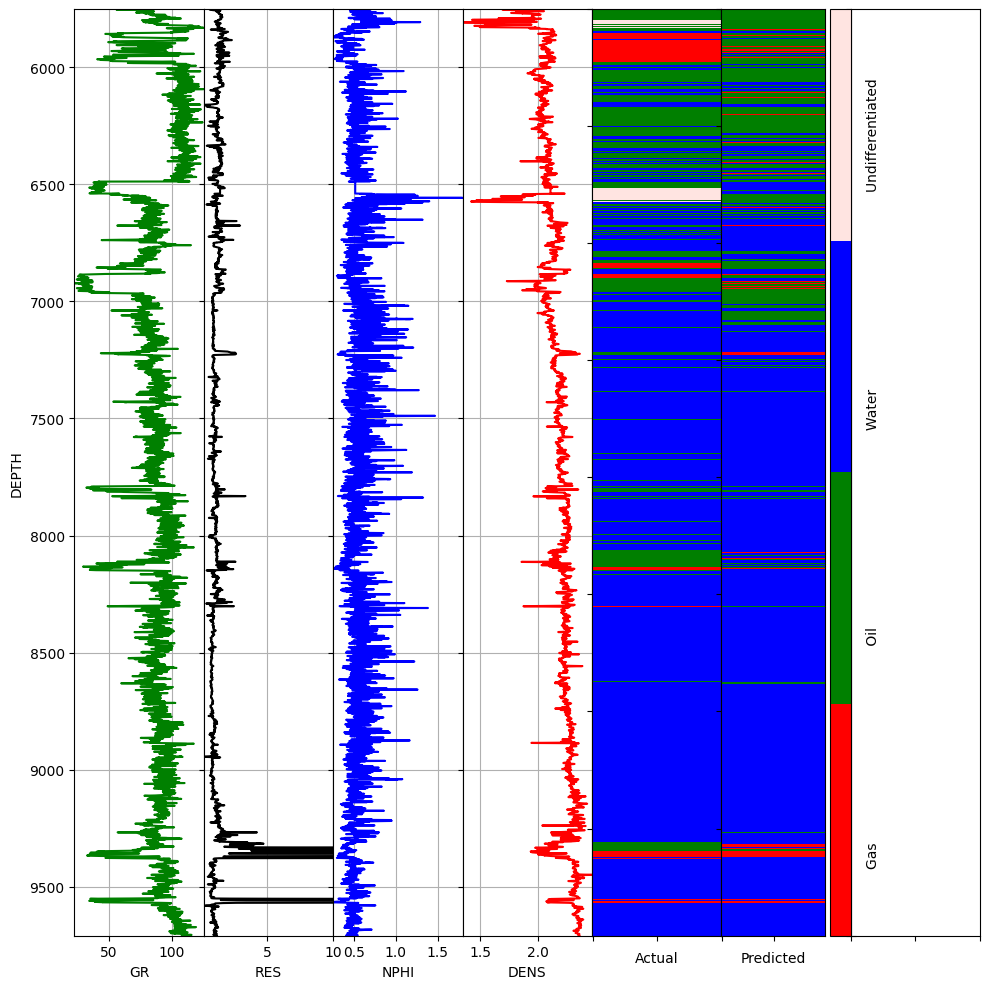

In [ ]:
freeman3st_2 = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1)+ (ntrain-dropped_train))]
freeman3st_2['PRED_FLUIDTYPES'] = y_pred_1
# visulaize plot
compare_fluidtype_log_plot(freeman3st_2,'GR','RES','NPHI','DENS')

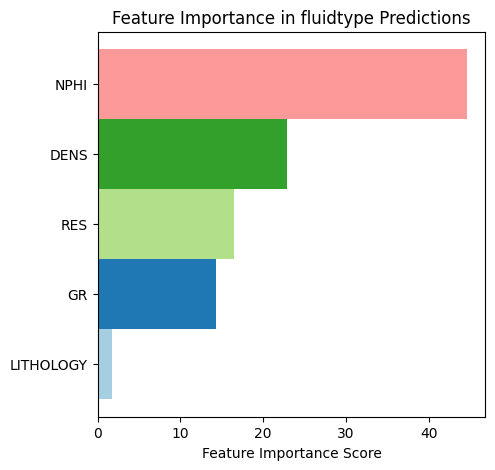

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(catboost_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');

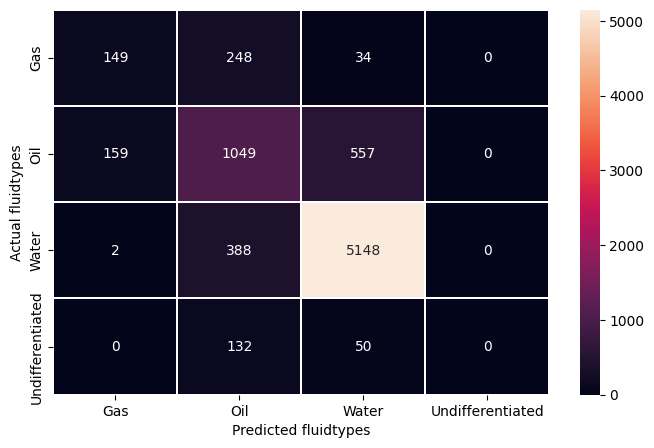

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_1, y_pred_1)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water','Undifferentiated'], columns=['Gas', 'Oil', 'Water','Undifferentiated'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

##Freeman 05

In [ ]:
# concatenate pearl, Ataga, Test_3, Test_1
train_data = pd.concat ((Pearl,Ataga,Test_1,Test_3))
train_data = train_data.reset_index()
Test_2 = Test_2.reset_index()

In [ ]:
new_train_data = pd.concat((train_data,validation_data_1,validation_data_2)).drop_duplicates(keep=False)
print(f'Previous train data shape: {train_data.shape}')
print(f'New train data shape: {new_train_data.shape}')

Previous train data shape: (156442, 8)
New train data shape: (125218, 8)


In [ ]:
# check for data leakage
print (f'Original train data rows: {train_data.shape[0]}')
print (f'New_train + Validation rows: {new_train_data.shape[0] + validation_data_1.shape[0] + validation_data_2.shape[0]}')

Original train data rows: 156442
New_train + Validation rows: 156442


In [ ]:
# row numbers
ntrain = new_train_data.shape[0]
ntest_2 = Test_2.shape[0]

In [ ]:
## concatenating new_train_data, Test_2,and val 1 & 2 for combined cleaning
df = pd.concat((new_train_data,Test_2,validation_data_1,validation_data_2)).reset_index(drop=True)

In [ ]:
## Drop rows where FLUIDTYPES is NAN
df = df.dropna(subset=['FLUIDTYPES'])
# Do the same for LITHOLOGY
df = df.dropna(subset=['LITHOLOGY'])

In [ ]:
# Train_data
count_missing_lithology = pd.isna(new_train_data['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(new_train_data['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")

count_missing_values = ((pd.isna(new_train_data['FLUIDTYPES'])) & (pd.isna(new_train_data['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 216
Number of rows with missing values in FLUIDTYPES: 3815
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 84


In [ ]:
##Test 2
count_missing_lithology = pd.isna(Test_2['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(Test_2['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")

count_missing_values = ((pd.isna(Test_2['FLUIDTYPES'])) & (pd.isna(Test_2['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 549
Number of rows with missing values in FLUIDTYPES: 557
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 549


In [ ]:
dropped_train = 216 + 3815 - 84
dropped_test_2 = 557 + 549 - 549

In [ ]:
## replace missing values in numerical variables with -999
df['DENS'] = df['DENS'].fillna(-999)
df['NPHI'] = df['NPHI'].fillna(-999)
df['RES'] = df['RES'].fillna(-999)

In [ ]:
df_copy = df.copy()

In [ ]:
## split back the df into train, test datasets
train = df_copy[:(ntrain-dropped_train)].copy()
train.drop(['FLUIDTYPES'], axis=1, inplace=True)

test_2 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_2-dropped_test_2))].copy()
test_2.drop(['FLUIDTYPES'],axis=1,inplace=True)
test_2 = test_2.reset_index(drop=True)

In [ ]:
# defining X_train and y_train
X_train = train.drop(['WELLNAME','DEPT'], axis=1)
y_train = df_copy[:(ntrain-dropped_train)]['FLUIDTYPES'].astype('int')

# defining X_test_2 and y_test_2
X_test_2 = test_2.drop(["WELLNAME",'DEPT'], axis=1)
y_test_2 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_2-dropped_test_2))]['FLUIDTYPES'].astype('int')

In [ ]:
(y_test_2.value_counts()/y_test_2.shape[0])*100

2    85.41765
1     8.57008
0     6.01227
Name: FLUIDTYPES, dtype: float64

In [ ]:
X_train

,DENS,GR,NPHI,RES,LITHOLOGY
37,2.0155,25.944000,-999.000,38.841999,0.0
38,1.9773,25.424999,-999.000,35.256001,0.0
39,1.9485,26.393000,-999.000,31.393999,0.0
40,1.9428,27.667000,-999.000,31.843000,0.0
41,1.9428,29.193001,-999.000,34.314999,0.0
...,...,...,...,...,...
125210,2.1781,1.687900,0.471,-999.000000,0.0
125211,2.1551,1.689400,0.471,-999.000000,0.0
125212,2.1480,1.691000,0.471,-999.000000,0.0
125213,2.1419,1.692700,0.471,-999.000000,0.0


####RandomForestClassifier model training

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# initializing the model
rfc = RandomForestClassifier(n_estimators = 300,
                             max_depth = 5,
                             random_state=42,
                             verbose =2,
                            )

# fit the model to the data
rfc.fit(X_train,y_train)

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.1s


building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   14.1s


building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300


RandomForestClassifier(max_depth=5, n_estimators=300, random_state=42,
                       verbose=2)

In [ ]:
# predictions on the test dataset

# Freeman 05
y_pred_2 = rfc.predict(X_test_2)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score

acc_test_2 = accuracy_score(y_test_2,y_pred_2)
print ("Accuracy score for Freeman 05 well: %.5f" %acc_test_2)

Accuracy score for Freeman 05 well: 0.82860


In [ ]:
freeman5 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_2-dropped_test_2))]
freeman5['PRED_FLUIDTYPES'] = y_pred_2
# visulaize plot

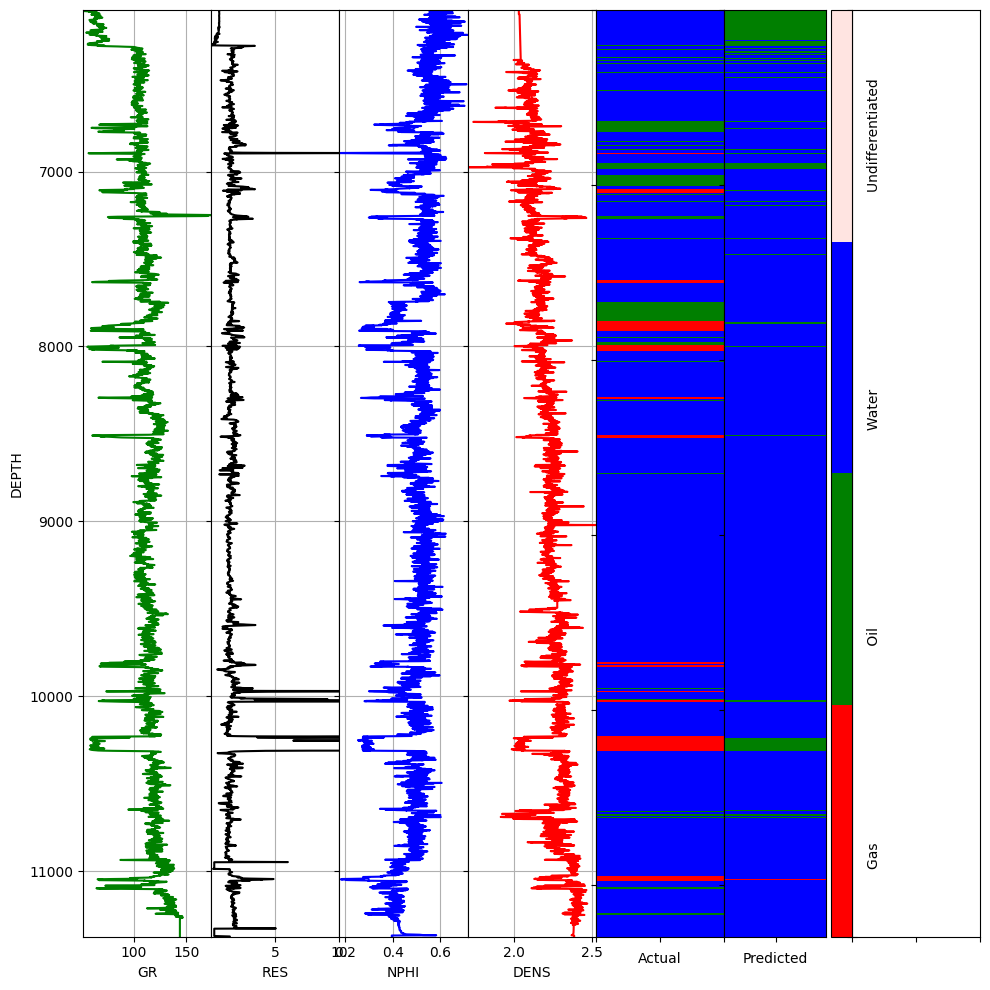

In [ ]:

compare_fluidtype_log_plot(freeman5,'GR','RES','NPHI','DENS')

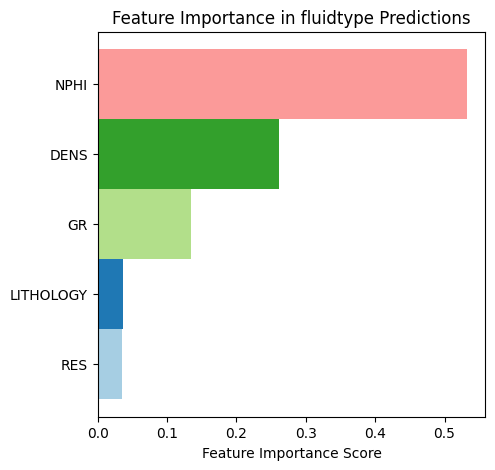

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');


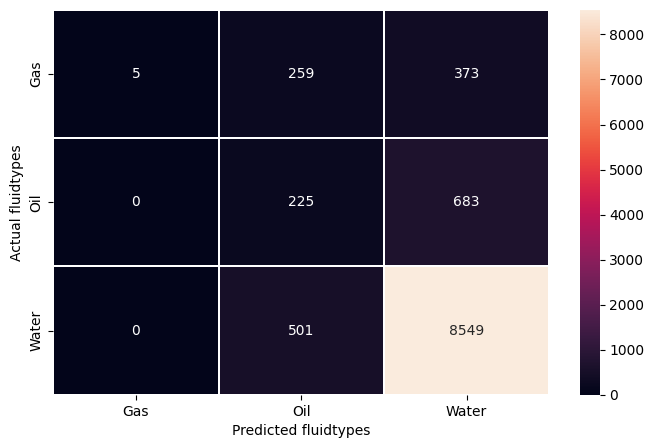

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_2, y_pred_2)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water'], columns=['Gas', 'Oil', 'Water'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

####XGBoostClassifier Model training

In [ ]:
import xgboost as xgb

num_classes = 4

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

## instantiate xgboost classifier model
xgbc = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=5,
    scale_pos_weight=class_weights,
)
## train the model
xgbc.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:25:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# predictions on the test datasets

# Freeman 05
y_pred_2 = xgbc.predict(X_test_2)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_2 = accuracy_score(y_test_2,y_pred_2)


print("Accuracy score for Freeman 05 well: %.5f" %acc_test_2)
print("------------------------------------------------------")

classification_rep_2 = classification_report(y_test_2, y_pred_2)
print (classification_rep_2)

Accuracy score for Freeman 05 well: 0.84483
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.33      0.48       637
           1       0.35      0.58      0.44       908
           2       0.93      0.91      0.92      9050
           3       0.00      0.00      0.00         0

    accuracy                           0.84     10595
   macro avg       0.54      0.45      0.46     10595
weighted avg       0.88      0.84      0.85     10595



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
freeman5_1 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_2-dropped_test_2))]
freeman5_1['PRED_FLUIDTYPES'] = y_pred_2

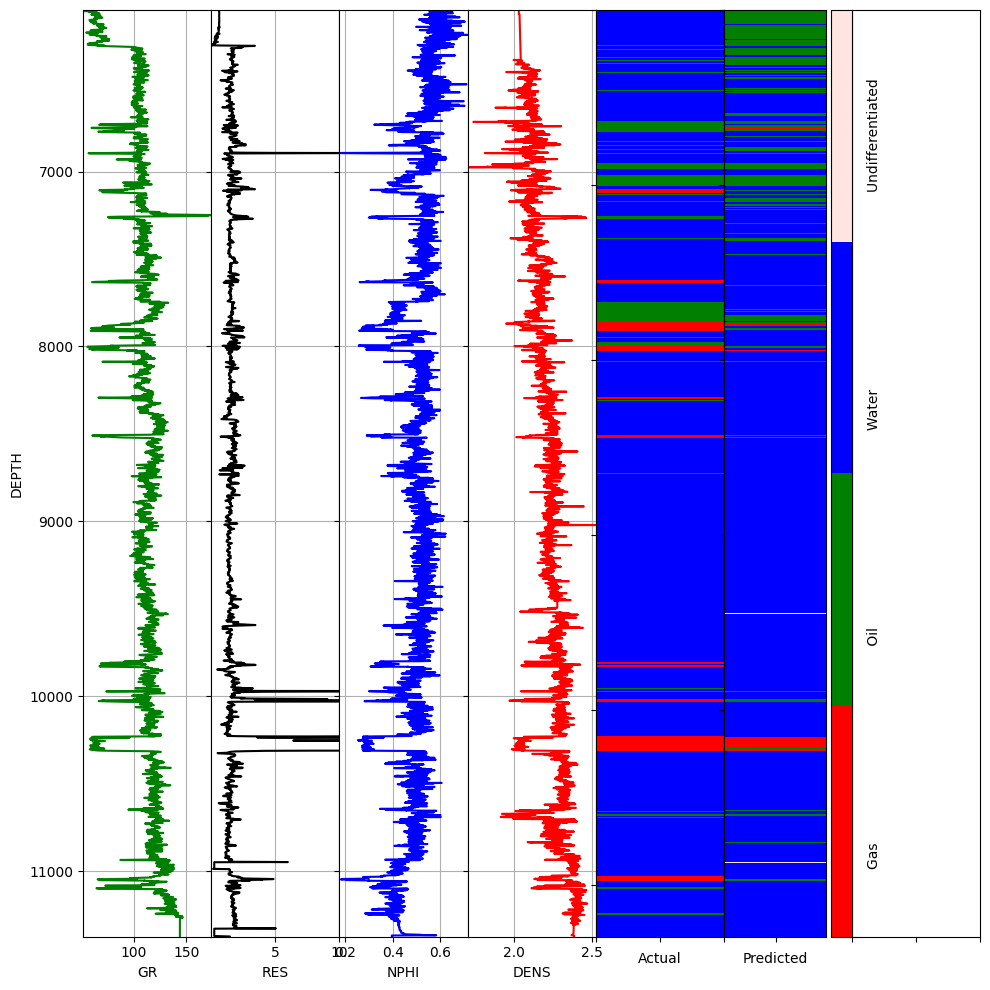

In [ ]:

# visulaize plot
compare_fluidtype_log_plot(freeman5_1,'GR','RES','NPHI','DENS')

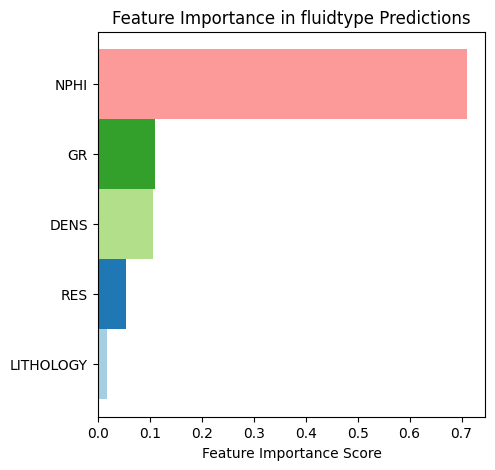

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');

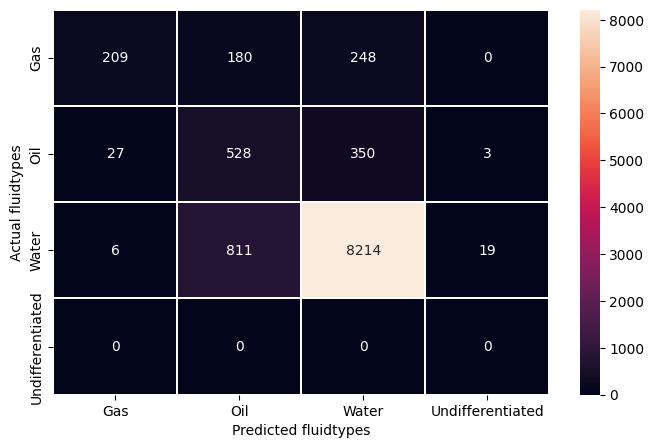

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_2, y_pred_2)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water','Undifferentiated'], columns=['Gas', 'Oil', 'Water','Undifferentiated'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

####CatboostClassifier model training

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test_2, label = y_test_2)

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

catboost_model = CatBoostClassifier(class_weights=class_weights,iterations = 100, depth=2, learning_rate=0.1, loss_function='MultiClass' )
catboost_model.fit(train_pool, eval_set= test_pool, early_stopping_rounds=50, verbose=50)

0:	learn: 1.2581796	test: 1.3197258	best: 1.3197258 (0)	total: 84.6ms	remaining: 8.38s
50:	learn: 0.5153841	test: 0.8366261	best: 0.8355403 (49)	total: 3.35s	remaining: 3.22s
99:	learn: 0.4398706	test: 0.7871214	best: 0.7852999 (96)	total: 5.44s	remaining: 0us

bestTest = 0.7852998672
bestIteration = 96

Shrink model to first 97 iterations.


In [ ]:
# predictions on the test datasets

# Freeman 05
y_pred_2 = catboost_model.predict(X_test_2)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_2 = accuracy_score(y_test_2,y_pred_2)

print("Accuracy score for Freeman 05 well: %.5f" %acc_test_2)
print('--------------------------------------')

classification_rep_2 = classification_report(y_test_2, y_pred_2)
print (classification_rep_2)


Accuracy score for Freeman 05 well: 0.81831
--------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.54      0.69       637
           1       0.24      0.43      0.30       908
           2       0.92      0.88      0.90      9050

    accuracy                           0.82     10595
   macro avg       0.70      0.62      0.63     10595
weighted avg       0.87      0.82      0.84     10595



In [ ]:
freeman5_2 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_2-dropped_test_2))]
freeman5_2['PRED_FLUIDTYPES'] = y_pred_2

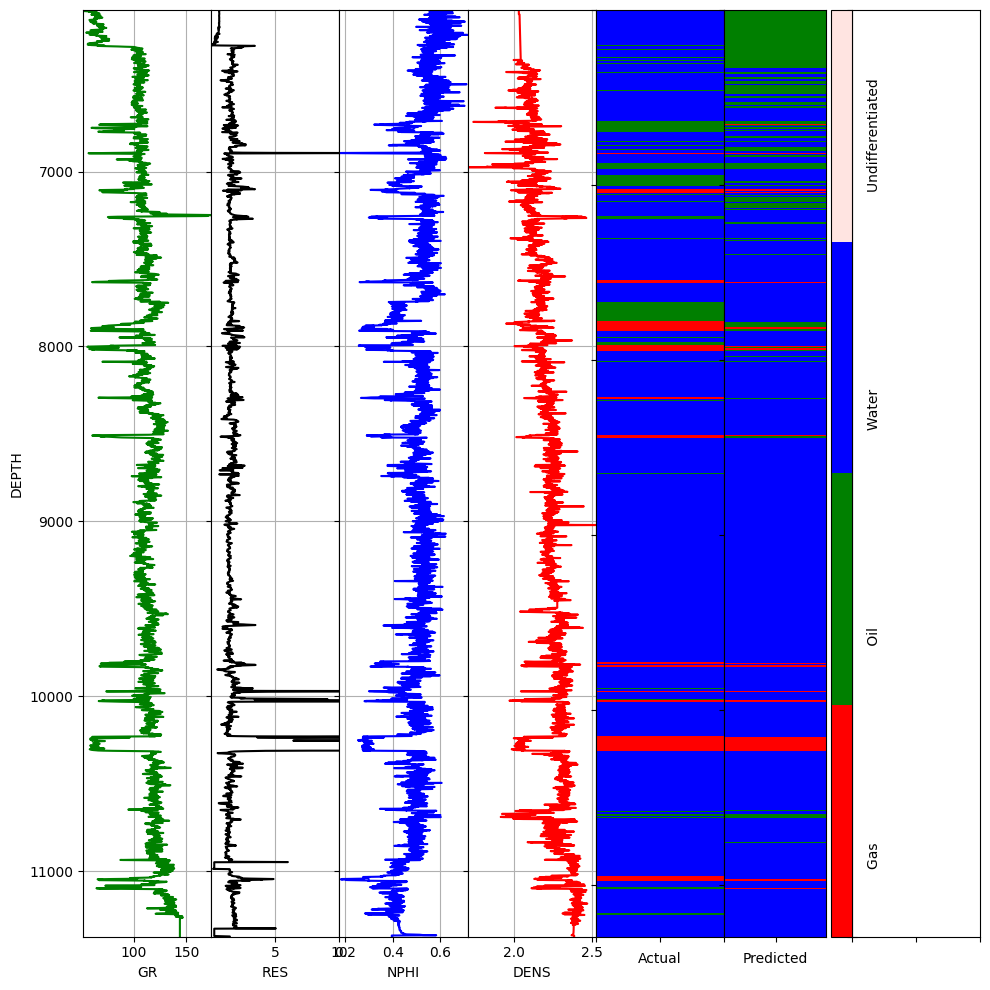

In [ ]:
# visulaize plot
compare_fluidtype_log_plot(freeman5_2,'GR','RES','NPHI','DENS')

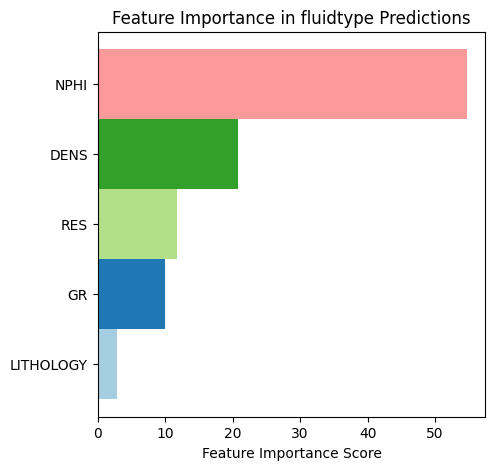

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(catboost_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');

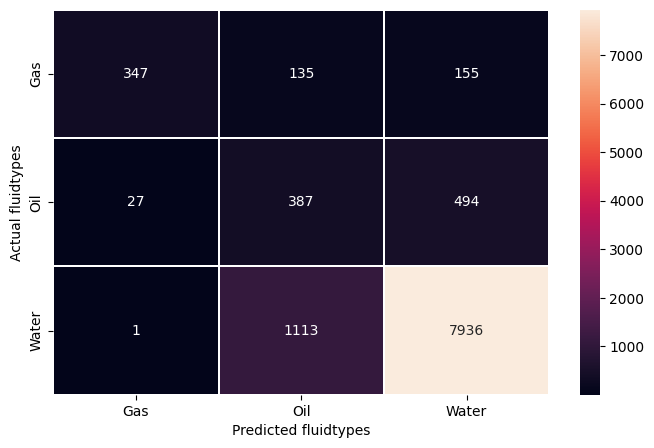

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_2, y_pred_2)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water'], columns=['Gas', 'Oil', 'Water'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

##Freeman 01

In [ ]:
# concatenate pearl, Ataga, Test_2, Test_1
train_data = pd.concat ((Pearl,Ataga,Test_1,Test_2))
train_data = train_data.reset_index()
Test_3 = Test_3.reset_index()

In [ ]:
new_train_data = pd.concat((train_data,validation_data_1,validation_data_2)).drop_duplicates(keep=False)
print(f'Previous train data shape: {train_data.shape}')
print(f'New train data shape: {new_train_data.shape}')

Previous train data shape: (147603, 8)
New train data shape: (116379, 8)


In [ ]:
# check for data leakage
print (f'Original train data rows: {train_data.shape[0]}')
print (f'New_train + Validation rows: {new_train_data.shape[0] + validation_data_1.shape[0] + validation_data_2.shape[0]}')

Original train data rows: 147603
New_train + Validation rows: 147603


In [ ]:
# row numbers
ntrain = new_train_data.shape[0]
ntest_3 = Test_3.shape[0]

In [ ]:
## concatenating new_train_data, Test_3,and val 1 & 2 for combined cleaning
df = pd.concat((new_train_data,Test_3,validation_data_1,validation_data_2)).reset_index(drop=True)

In [ ]:
## Drop rows where FLUIDTYPES is NAN
df = df.dropna(subset=['FLUIDTYPES'])
# Do the same for LITHOLOGY
df = df.dropna(subset=['LITHOLOGY'])

In [ ]:
# Train_data
count_missing_lithology = pd.isna(new_train_data['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(new_train_data['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")

count_missing_values = ((pd.isna(new_train_data['FLUIDTYPES'])) & (pd.isna(new_train_data['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 764
Number of rows with missing values in FLUIDTYPES: 4304
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 632


In [ ]:
##Test 3
count_missing_lithology = pd.isna(Test_3['LITHOLOGY']).sum()
count_missing_fluidtypes = pd.isna(Test_3['FLUIDTYPES']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")
print(f"Number of rows with missing values in FLUIDTYPES: {count_missing_fluidtypes}")

count_missing_values = ((pd.isna(Test_3['FLUIDTYPES'])) & (pd.isna(Test_3['LITHOLOGY']))).sum()
print(f"Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: {count_missing_values}")

Number of rows with missing values in LITHOLOGY: 1
Number of rows with missing values in FLUIDTYPES: 68
Number of rows with simultaneous missing values in FLUIDTYPES and LITHOLOGY: 1


In [ ]:
dropped_train = 764 + 4304 - 632
dropped_test_3 = 68

In [ ]:
## replace missing values in numerical variables with -999
df['DENS'] = df['DENS'].fillna(-999)
df['NPHI'] = df['NPHI'].fillna(-999)
df['RES'] = df['RES'].fillna(-999)

In [ ]:
df_copy = df.copy()

In [ ]:
## split back the df into train, test and val datasets
train = df_copy[:(ntrain-dropped_train)].copy()
train.drop(['FLUIDTYPES'], axis=1, inplace=True)

test_3 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_3-dropped_test_3))].copy()
test_3.drop(['FLUIDTYPES'],axis=1,inplace=True)
test_3 = test_3.reset_index(drop=True)

In [ ]:
# defining X_train and y_train
X_train = train.drop(['WELLNAME','DEPT'], axis=1)
y_train = df_copy[:(ntrain-dropped_train)]['FLUIDTYPES'].astype('int')

# defining X_test_2 and y_test_2
X_test_3 = test_3.drop(["WELLNAME",'DEPT'], axis=1)
y_test_3 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_3-dropped_test_3))]['FLUIDTYPES'].astype('int')

In [ ]:
Test_3['RES'].min()

0.2300000042

In [ ]:
Test_3['DENS'].min(), Test_3['DENS'].max()

(1.5851999521, 2.8108999729)

In [ ]:
Test_3['NPHI'].min(), Test_3['NPHI'].max()

(0.0542000011, 0.7325000167)

In [ ]:
X_test_3['RES'].max()

22773.910156

In [ ]:
(y_test_3.value_counts()/y_test_3.shape[0])*100

2    56.638057
3    18.757215
1    18.571500
0     6.033228
Name: FLUIDTYPES, dtype: float64

####RandomForestClassifier model training

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# initializing the model
rfc = RandomForestClassifier(n_estimators = 300,
                             max_depth = 5,
                             random_state=42,
                             verbose=2,
                             bootstrap=True)

# fit the model to the data
rfc.fit(X_train,y_train)

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.6s


building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   13.1s


building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300


RandomForestClassifier(max_depth=5, n_estimators=300, random_state=42,
                       verbose=2)

In [ ]:
# predictions on the test dataset

# Freeman 01
y_pred_3 = rfc.predict(X_test_3)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score

acc_test_3 = accuracy_score(y_test_3,y_pred_3)
print ("Accuracy score for Freeman 01 well: %.5f" %acc_test_3)

Accuracy score for Freeman 01 well: 0.78894


In [ ]:
## function to plot predictions

def compare_fluidtype_log_plot(logs, x1, x2, x3, x4):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.colors as colors

    logs = logs.sort_values(by='DEPT', ascending=True)
    ztop = logs.DEPT.min(); zbot=logs.DEPT.max()

    #for fluidtypes
    fluidtype_colors = ['r','g', 'b','mistyrose']
    fluidtype_names = ['Gas','Oil','Water','Undifferentiated']
    fluidtype_colormap = {}
    for ind, label in enumerate(fluidtype_names):
        fluidtype_colormap[label] = fluidtype_colors[ind]

    cmap_fluidtype = colors.ListedColormap(
            fluidtype_colors[0 : 5], 'indexed'
            )

    cluster1=np.repeat(np.expand_dims(logs['FLUIDTYPES'].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs['PRED_FLUIDTYPES'].values,1), 100, 1)

    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(10, 10))

    ax[0].plot(logs[x1], logs.DEPT, '-g')
    ax[1].plot(logs[x2], logs.DEPT, '-', color= 'black')
    ax[2].plot(logs[x3], logs.DEPT, '-', color='blue')
    ax[3].plot(logs[x4], logs.DEPT, '-', color='r')

    im=ax[4].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_fluidtype,vmin=0,vmax=3)
    im=ax[5].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_fluidtype,vmin=0,vmax=3)


    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad='5%')
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((45*' ').join([
        'Gas','Oil','Water','Undifferentiated'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    for i in range(len(ax)-3):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel(x1)
    ax[0].set_ylabel('DEPTH')
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(0.1, 100)
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(0.05, logs[x3].max()) #(0.0542000011, 0.7325000167)
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(1.0, logs[x4].max()) #(1.5851999521, 2.8108999729)
    ax[4].set_xlabel('Actual')
    ax[5].set_xlabel('Predicted')

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[4].set_xticklabels([]); ax[5].set_yticklabels([]);
    ax[6].set_yticklabels([]); ax[5].set_xticklabels([]); ax[6].set_xticklabels([]);


    plt.tight_layout(h_pad=1)
    f.subplots_adjust(wspace = 0.0)
    #f.suptitle('Well: %s'% logs['WELLNAME'].unique(), fontsize=14,y=0.94)

<ipython-input-315-4ed76889061c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freeman1_1['PRED_FLUIDTYPES'] = y_pred_3


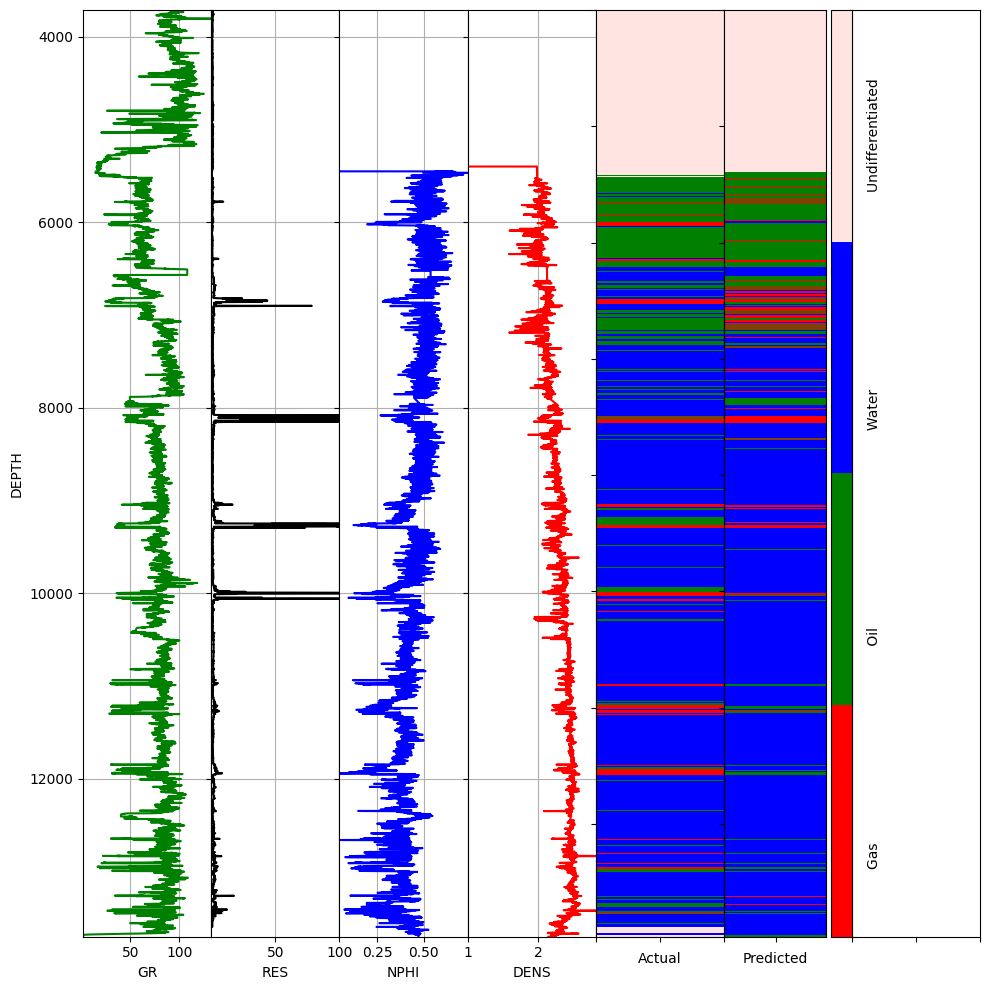

In [ ]:
freeman1_1 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_3-dropped_test_3))]
freeman1_1['PRED_FLUIDTYPES'] = y_pred_3
# visulaize plot
compare_fluidtype_log_plot(freeman1_1,'GR','RES','NPHI','DENS')

In [ ]:
X_train.head()

,DENS,GR,NPHI,RES,LITHOLOGY
37,2.0155,25.944000,-999.0,38.841999,0.0
38,1.9773,25.424999,-999.0,35.256001,0.0
39,1.9485,26.393000,-999.0,31.393999,0.0
40,1.9428,27.667000,-999.0,31.843000,0.0
41,1.9428,29.193001,-999.0,34.314999,0.0


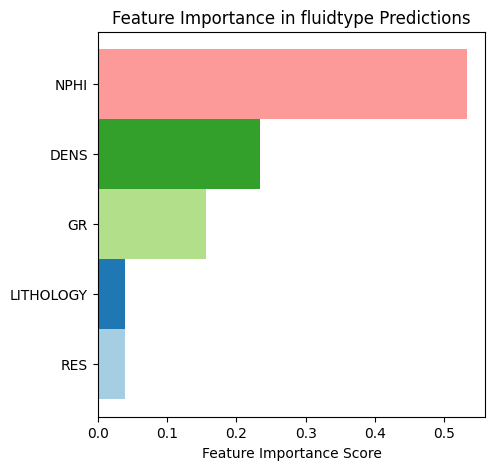

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');

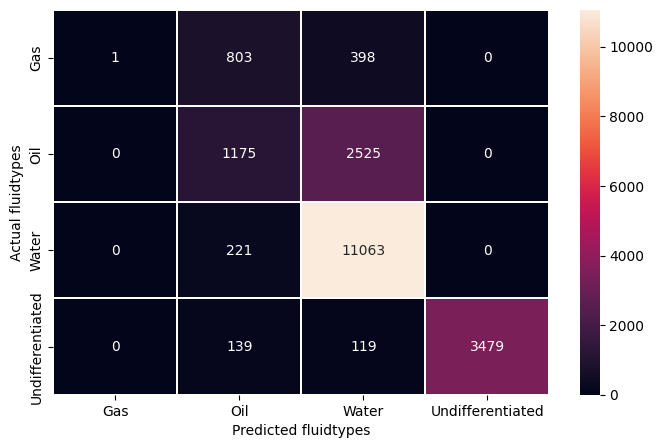

In [ ]:

## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_3, y_pred_3)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water','Undifferentiated'], columns=['Gas', 'Oil', 'Water','Undifferentiated'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

####XGBoostClassifier Model training

In [ ]:
import xgboost as xgb

num_classes = 4

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

## instantiate xgboost classifier model
xgbc = xgb.XGBClassifier(n_estimators = 100, Objective = 'multi:softmax',num_class = num_classes, scale_pos_weight= class_weights, random_state=42)

## train the model
xgbc.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:48:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(Objective='multi:softmax', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=4, ...)

In [ ]:
# predictions on the test datasets

# Freeman 01
y_pred_3 = xgbc.predict(X_test_3)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


acc_test_3 = accuracy_score(y_test_3,y_pred_3)


print("Accuracy score for Freeman 01 well: %.5f" %acc_test_3)
print('-----------------------------------------------------------')


classification_rep_3 = classification_report(y_test_3, y_pred_3)
print (classification_rep_3)



Accuracy score for Freeman 01 well: 0.81162
-----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.43      0.16      0.23      1202
           1       0.60      0.49      0.54      3700
           2       0.83      0.95      0.88     11284
           3       0.99      0.93      0.96      3737

    accuracy                           0.81     19923
   macro avg       0.71      0.63      0.65     19923
weighted avg       0.79      0.81      0.79     19923



In [ ]:
freeman1_2 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_3-dropped_test_3))]
freeman1_2['PRED_FLUIDTYPES'] = y_pred_3

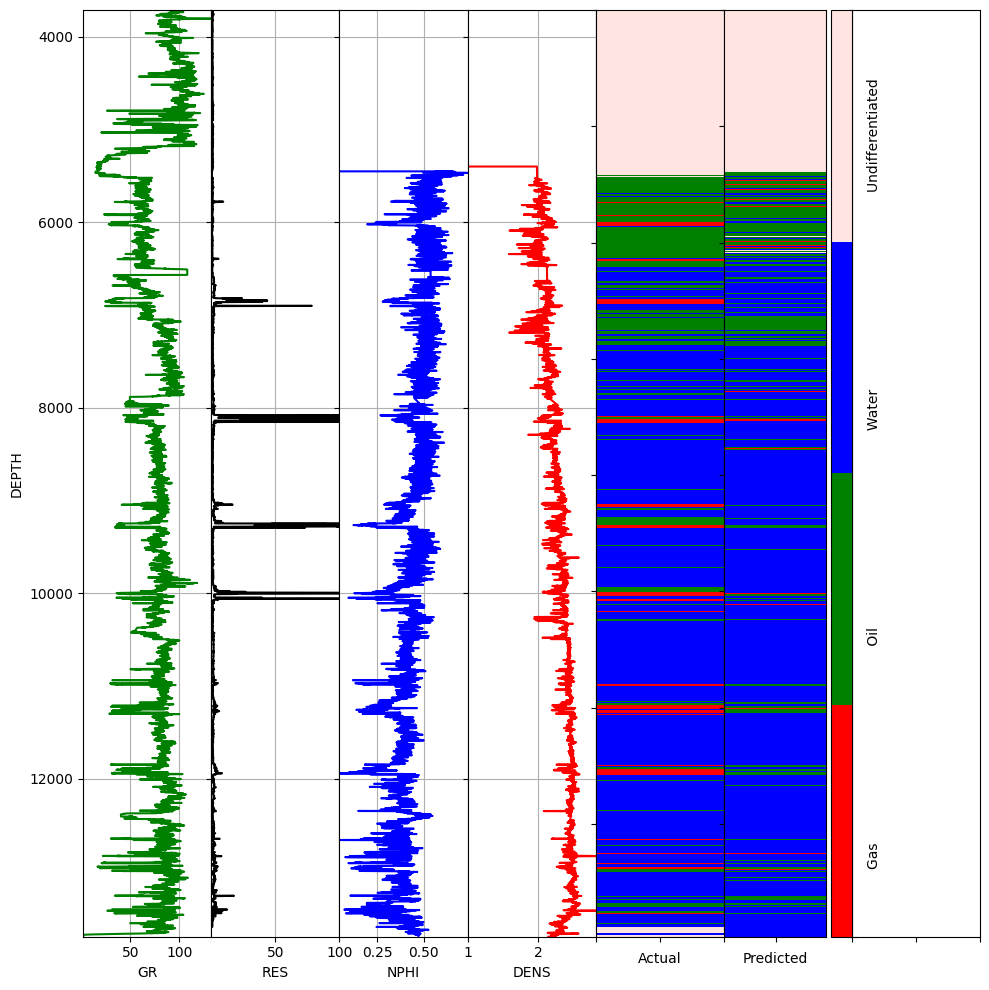

In [ ]:

# visulaize plot
compare_fluidtype_log_plot(freeman1_2,'GR','RES','NPHI','DENS')

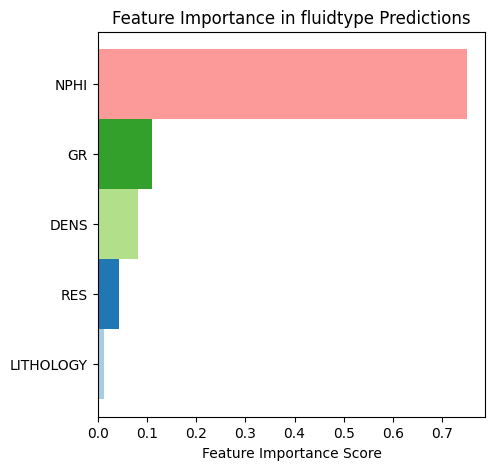

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');

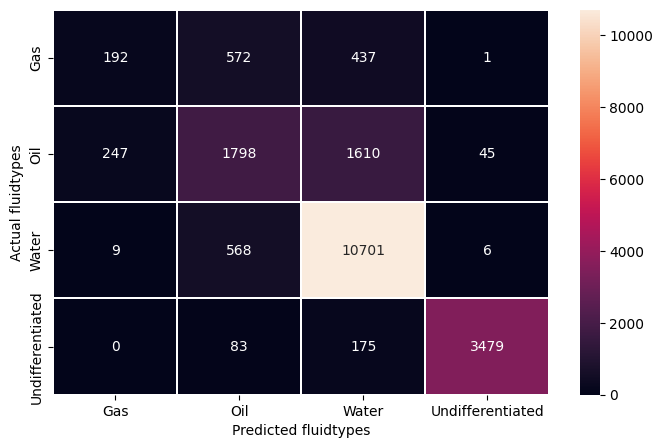

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_3, y_pred_3)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water','Undifferentiated'], columns=['Gas', 'Oil', 'Water','Undifferentiated'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

#### CatboostClassifier model training

In [ ]:
train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test_3, label = y_test_3)

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

catboost_model = CatBoostClassifier(class_weights=class_weights,iterations = 300, depth=2, learning_rate=0.1, loss_function='MultiClass' )
catboost_model.fit(train_pool, eval_set= test_pool, early_stopping_rounds=50, verbose=100)

0:	learn: 1.2651349	test: 1.3086504	best: 1.3086504 (0)	total: 45.8ms	remaining: 13.7s
100:	learn: 0.4277004	test: 0.9308439	best: 0.9101204 (69)	total: 6.52s	remaining: 12.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.91012043
bestIteration = 69

Shrink model to first 70 iterations.


In [ ]:
# predictions on the test datasets

# Freeman 01
y_pred_3 = catboost_model.predict(X_test_3)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_3 = accuracy_score(y_test_3,y_pred_3)

print("Accuracy score for Freeman 01 well: %.5f" %acc_test_3)
print('--------------------------------------')

classification_rep_3 = classification_report(y_test_3, y_pred_3)
print (classification_rep_3)

Accuracy score for Freeman 01 well: 0.82146
--------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.40      0.36      1202
           1       0.62      0.52      0.57      3700
           2       0.88      0.93      0.90     11284
           3       1.00      0.93      0.96      3737

    accuracy                           0.82     19923
   macro avg       0.71      0.69      0.70     19923
weighted avg       0.82      0.82      0.82     19923



In [ ]:
freeman1_3 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_3-dropped_test_3))]
freeman1_3['PRED_FLUIDTYPES'] = y_pred_3

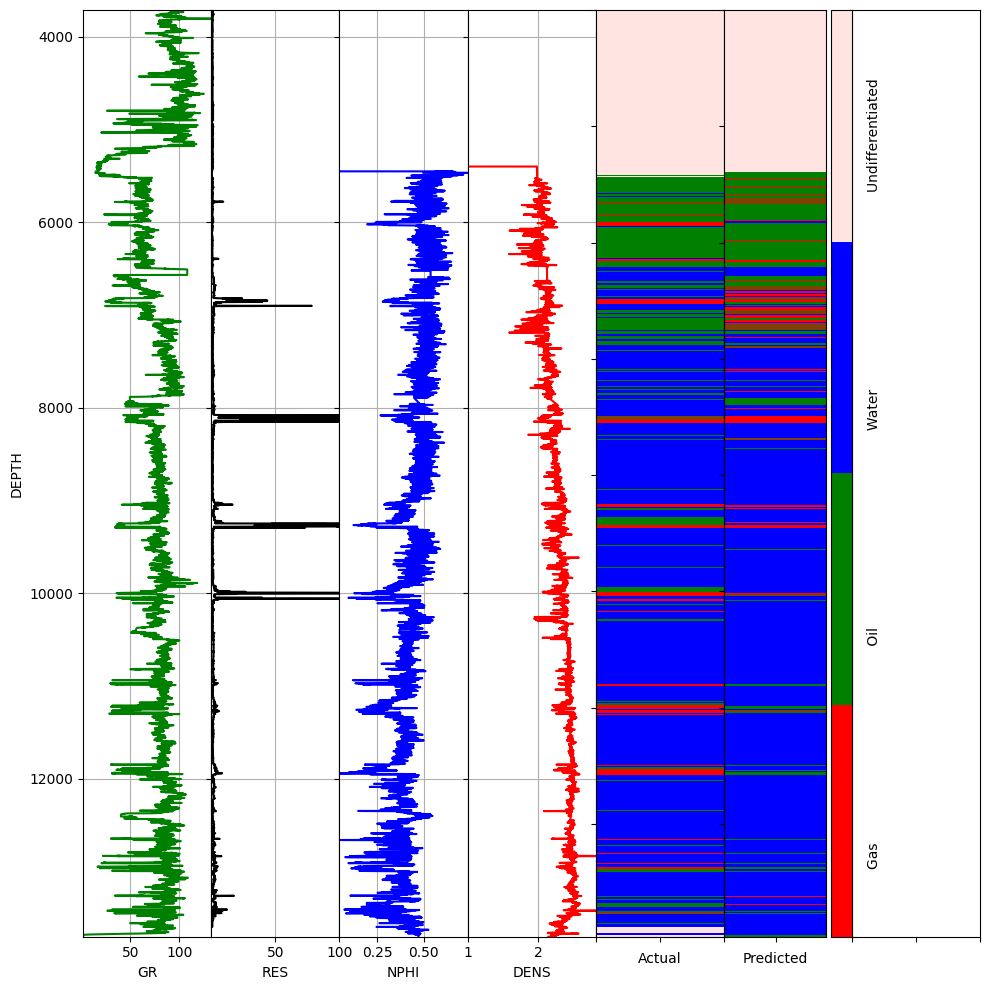

In [ ]:

# visulaize plot
compare_fluidtype_log_plot(freeman1_3,'GR','RES','NPHI','DENS')

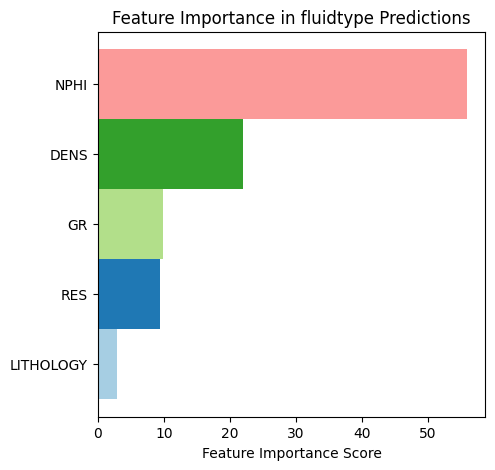

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(catboost_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in fluidtype Predictions')
plt.xlabel('Feature Importance Score');


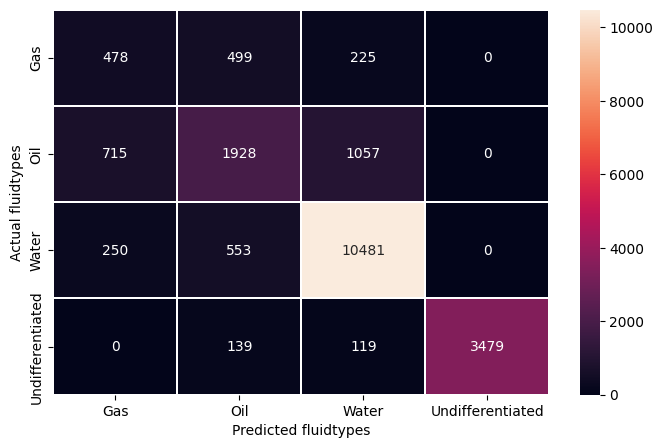

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_3, y_pred_3)

cf = pd.DataFrame(cf, index=['Gas', 'Oil', 'Water','Undifferentiated'], columns=['Gas', 'Oil', 'Water','Undifferentiated'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted fluidtypes'); plt.ylabel('Actual fluidtypes');

In [ ]:
## save model
import pickle

import pickle

model_filename = 'catboost_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(catboost_model, file)

## THE END ✈